# Testing LOSD
### Neubauwohnungen am Jahresende nach Bauprojektstatus, Zimmerzahl und Stadtquartier

Der Datensatz enthält die Anzahl bewilligter und im Bau befindlicher Wohnungen in Neubauprojekten nach Zimmerzahl und Stadtquartier.

https://data.integ.stadt-zuerich.ch/dataset/bau502od5022


Datum: 22.05.2024

### Colab
Mit Colab kann das Jupyter-Notebook interaktiv im Browser gestartet werden. 

Klicke auf den Button:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DonGoginho/colab/blob/main/losd/colab_b_bau5022_losd_bau_neubau_whg-projektiert_projstatus_zizahl_quartier_seit2009_od5022.ipynb)


### Importiere die notwendigen Packages

In [1]:
#%pip install altair datetime folium geopandas io requests matplotlib numpy pandas seaborn plotly
!pip install altair==5.0.1 vl-convert-python


In [2]:
import altair as alt
import datetime
import folium 
import geopandas as gpd
import io
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import pivottablejs
#from pivottablejs import pivot_ui
import plotly.express as px
import requests
import seaborn as sns

Importiere die eigenen Funktionen, die unter ../0_scripts abegelegt sind:

1) Klone das Github-Repo auf Colab. Sonst werden die Skripts nicht gelesen...

In [ ]:
!git clone https://github.com/DonGoginho/colab.git


fatal: destination path 'colab' already exists and is not an empty directory.


2) Checke die Schreibrechte in den geklonten Verzeichnissen

In [ ]:
!ls -l /content/colab
!ls -l /content/colab/losd


total 20
drwxr-xr-x 4 root root 4096 Jul  3 12:58 0_scripts
drwxr-xr-x 2 root root 4096 Jul  3 12:58 archiv
-rw-r--r-- 1 root root 1211 Jul  3 12:58 LICENSE
drwxr-xr-x 5 root root 4096 Jul  3 12:58 losd
-rw-r--r-- 1 root root 1755 Jul  3 12:58 README.md
total 4484
-rw-r--r-- 1 root root  216728 Jul  3 12:58 bev3160_losd_bev_bestand_jahr_konfession_od3160.ipynb
-rw-r--r-- 1 root root 1755589 Jul  3 12:58 bev3240_losd_bev_bestand_jahr_quartier_od3240.ipynb
-rw-r--r-- 1 root root  696643 Jul  3 12:58 bev3241_losd_bev_bestand_jahr_statzonen_od3241.ipynb
-rw-r--r-- 1 root root 1152082 Jul  3 12:58 bev3242_losd_bev_bestand_jahr_kreis_od3242.ipynb
-rw-r--r-- 1 root root  285094 Jul  3 12:58 bev3243_losd_bev_bestand_jahr_od3243.ipynb
-rw-r--r-- 1 root root  461744 Jul  3 12:58 colab_bev3243_losd_bev_bestand_jahr_od3243.ipynb
drwxr-xr-x 2 root root    4096 Jul  3 12:59 grafiken_testing
drwxr-xr-x 2 root root    4096 Jul  3 12:58 org_ipynb
drwxr-xr-x 2 root root    4096 Jul  3 12:58 saved_data


3) Importiere die Skripts

In [ ]:
import sys
sys.path.append('/content/colab/0_scripts')

import my_py_dataviz_functions as mypy_dv
import my_py_dataloading_functions as mypy_dl

In [4]:
SSL_VERIFY = False
# evtl. SSL_VERIFY auf False setzen wenn die Verbindung zu https://www.gemeinderat-zuerich.ch nicht klappt (z.B. wegen Proxy)
# Um die SSL Verifikation auszustellen, bitte die nächste Zeile einkommentieren ("#" entfernen)
# SSL_VERIFY = False

In [5]:
if not SSL_VERIFY:
    import urllib3
    urllib3.disable_warnings()

### Settings
Definiere Settings. 
Hier das Zahlenformat von Float-Werten (z.B. *'{:,.2f}'.format* mit Komma als Tausenderzeichen)

In [6]:
#pd.options.display.float_format = lambda x : '{:,.1f}'.format(x) if (np.isnan(x) | np.isinf(x)) else '{:,.0f}'.format(x) if int(x) == x else '{:,.1f}'.format(x)
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('display.width', 100)
pd.set_option('display.max_columns', 15)

#### Zeitvariabeln

In [7]:
#Zeitvariabeln als Strings:
now = datetime.date.today()
year_today = now.strftime("%Y")
date_today = "_"+now.strftime("%Y-%m-%d")

#Zeitvariabeln als Integers:
int_times = now.timetuple()
aktuellesJahr = int_times[0]
aktuellerMonat = int_times[1]
selectedMonat = int_times[1]-2
#print(aktuellesJahr, aktuellerMonat,'datenstand: ', selectedMonat, int_times)

### Daten importieren und Metadaten checken

- status: int / prod
- data_source: web / ld / dropzone
- datums_attr: beschreibt das oder die Datumsfelder, die als Datum geparsed werden sollen. Falls es keines gibt: None

In [8]:
#speichere die variable global, damit ich sie später verwenden kann, wenn ich grafiken mit diesem namen speichere.
package_name = "bau502od5022"

In [9]:
sasa_data2betested = mypy_dl.load_data(
    status = 'prod'
    , data_source = 'web'
    , package_name = 'bau_neubau_whg-projektiert_projstatus_zizahl_quartier_seit2009_od5022'
    , dataset_name = "bau502od5022"    
    , datums_attr = ['StichtagDatJahr']
    )

sasa_data2betested.head(2)

fp lautet:https://data.stadt-zuerich.ch/dataset/bau_neubau_whg-projektiert_projstatus_zizahl_quartier_seit2009_od5022/download/BAU502OD5022.csv


 **Überprüfe die Metadaten:**

 **Dataset auf PROD-Datakatalog:** Link https://data.stadt-zuerich.ch/dataset/bau_neubau_whg-projektiert_projstatus_zizahl_quartier_seit2009_od5022 

 **Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/bau_neubau_whg-projektiert_projstatus_zizahl_quartier_seit2009_od5022 

data_source: web


,StichtagDatJahr,DatenstandCd,QuarSort,QuarCd,QuarLang,KreisSort,KreisCd,...,ArtArbeitenSort,ArtArbeitenCd,ArtArbeitenLang,AnzZimmerLevel2Sort_noDM,AnzZimmerLevel2Cd_noDM,AnzZimmerLevel2Lang_noDM,AnzWhgStat
0,2009-01-01,D,12,12,Hochschulen,1,1,...,1,N,Neubau,1,1,1-Zimmer,0
1,2009-01-01,D,12,12,Hochschulen,1,1,...,1,N,Neubau,2,2,2-Zimmer,0


In [10]:
data2betested = mypy_dl.load_data(
    status = 'int'
    , data_source = 'ld'
    , package_name = package_name
    , dataset_name = "bau502od5022.csv"    
    , datums_attr = ['ZEIT_LANG']
    )

fp lautet:https://ld.integ.stadt-zuerich.ch/statistics/view/BAU502OD5022/observation?format=csv


 **Überprüfe die Metadaten:**

 **Dataset auf INTEG-Datakatalog:** Link https://data.integ.stadt-zuerich.ch/dataset/bau502od5022 

 **View auf INTEG-LD:** Link https://ld.integ.stadt-zuerich.ch/statistics/view/BAU502OD5022 

data_source: web


In [11]:
data2betested.head(2).T

,0,1
ZEIT_LANG,2009-12-31 00:00:00,2019-12-31 00:00:00
ZEIT_CODE,Z31122009,Z31122019
RAUM_LANG,Gewerbeschule,Hottingen
RAUM_CODE,R00051,R00072
ZIM_LANG,"4- und 4,5-Zimmer Wohnung","3- und 3,5-Zimmer Wohnung"
ZIM_CODE,ZIM0004,ZIM0003
ARA_LANG,Neubau,Neubau
ARA_CODE,ARA2001,ARA2001
PST_LANG,Baubegonnen,"Bewilligt harmonisiert (Bewillgt, Freigegeben,..."
PST_CODE,PST0006,PST0101


Berechne weitere Attribute falls notwendig

In [12]:
data2betested = (
    data2betested
    .copy()
    .assign(
        #Aktualisierungs_Datum_str= lambda x: x.Aktualisierungs_Datum.astype(str),
        StichtagDatJahr = lambda x: x.ZEIT_LANG,
        StichtagDatJahr_str = lambda x: x.ZEIT_LANG.astype(str),
        Jahr = lambda x: x.ZEIT_LANG.dt.year,
        #Jahr_nbr = lambda x: x.ZEIT_CODE.str[-4:].astype(int),    
        RAUM_my_sort = lambda x: x.RAUM_CODE.str[-3:].astype(int),

    )
    .sort_values('ZEIT_LANG', ascending=False)
    )
data2betested.head(2).T

,259,5419
ZEIT_LANG,2023-12-31 00:00:00,2023-12-31 00:00:00
ZEIT_CODE,Z31122023,Z31122023
RAUM_LANG,Albisrieden,Affoltern
RAUM_CODE,R00091,R00111
ZIM_LANG,6- und mehr-Zimmer Wohnung,"1- und 1,5-Zimmer Wohnung"
ZIM_CODE,ZIM0060,ZIM0001
ARA_LANG,Neubau,Neubau
ARA_CODE,ARA2001,ARA2001
PST_LANG,"Bewilligt harmonisiert (Bewillgt, Freigegeben,...",Baubegonnen
PST_CODE,PST0101,PST0006


Zeitbereich aus den Daten:

In [13]:
data_max_date = str(max(data2betested.ZEIT_LANG).year)
data_min_date = str(min(data2betested.ZEIT_LANG).year)

print(f"Die Daten haben ein Minimumjahr von {data_min_date} und ein Maximumjahr von {data_max_date}")


Die Daten haben ein Minimumjahr von 2004 und ein Maximumjahr von 2023


Temp speichere die csv-Datei, da es immer wieder zu Ausfällen kommt. So kann ich mal den Report fertig bauen.

In [14]:
docname = package_name +date_today+".csv"
print(docname)

bau502od5022_2024-07-04.csv


In [15]:
data2betested.to_csv('/content/colab/losd/saved_data/'+docname, index=False)

### Einfache Datentests

In [16]:
data2betested.head(2).T

,259,5419
ZEIT_LANG,2023-12-31 00:00:00,2023-12-31 00:00:00
ZEIT_CODE,Z31122023,Z31122023
RAUM_LANG,Albisrieden,Affoltern
RAUM_CODE,R00091,R00111
ZIM_LANG,6- und mehr-Zimmer Wohnung,"1- und 1,5-Zimmer Wohnung"
ZIM_CODE,ZIM0060,ZIM0001
ARA_LANG,Neubau,Neubau
ARA_CODE,ARA2001,ARA2001
PST_LANG,"Bewilligt harmonisiert (Bewillgt, Freigegeben,...",Baubegonnen
PST_CODE,PST0101,PST0006


In [17]:
data2betested.info(memory_usage='deep', verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 6087 entries, 259 to 1371
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   ZEIT_LANG            6087 non-null   datetime64[ns]
 1   ZEIT_CODE            6087 non-null   object        
 2   RAUM_LANG            6087 non-null   object        
 3   RAUM_CODE            6087 non-null   object        
 4   ZIM_LANG             6087 non-null   object        
 5   ZIM_CODE             6087 non-null   object        
 6   ARA_LANG             6087 non-null   object        
 7   ARA_CODE             6087 non-null   object        
 8   PST_LANG             6087 non-null   object        
 9   PST_CODE             6087 non-null   object        
 10  WHG                  6087 non-null   float64       
 11  KREISEZH_LANG        6087 non-null   object        
 12  KREISEZH_CODE        6087 non-null   object        
 13  StichtagDatJahr      6087 non-null  

In [18]:
print(f'The dataset has {data2betested.shape[0]:,.0f} rows (observations) and {data2betested.shape[1]:,.0f} columns (variables).')
print(f'There seem to be {data2betested.duplicated().sum()} exact duplicates in the data.')

The dataset has 6,087 rows (observations) and 17 columns (variables).
There seem to be 0 exact duplicates in the data.


Welches sind die Quartiere ohne Werte bei BEW?

In [19]:
data2betested[np.isnan(data2betested.WHG)]

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,ZIM_LANG,ZIM_CODE,ARA_LANG,...,WHG,KREISEZH_LANG,KREISEZH_CODE,StichtagDatJahr,StichtagDatJahr_str,Jahr,RAUM_my_sort


### Verwende das Datum als Index

While we did already parse the `datetime` column into the respective datetime type, it currently is just a regular column. 
**To enable quick and convenient queries and aggregations, we need to turn it into the index of the DataFrame**

In [20]:
data2betested = data2betested.set_index("StichtagDatJahr") 
data2betested = data2betested.sort_index()

In [21]:
data2betested.index.year.unique()

Index([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018,
       2019, 2020, 2021, 2022, 2023],
      dtype='int32', name='StichtagDatJahr')

### Beschreibe einzelne Attribute

Beschreibe nicht numerische Attribute

In [22]:
# describe non-numerical features
try:
    with pd.option_context('display.float_format', '{:,.2f}'.format):
        display(data2betested.describe(exclude='number',datetime_is_numeric=True))
except:
    print("No categorical data in dataset.")

No categorical data in dataset.


Beschreibe numerische Attribute

In [23]:
# describe numerical features
try:
    with pd.option_context('display.float_format', '{:,.0f}'.format):
        display(data2betested.describe(include='number'))
except:
    print("No numercial data in dataset.")

,WHG,Jahr,RAUM_my_sort
count,"6,087","6,087","6,087"
mean,27,"2,014",69
std,55,5,34
min,0,"2,004",11
25%,0,"2,010",41
50%,6,"2,015",72
75%,27,"2,019",101
max,637,"2,023",123


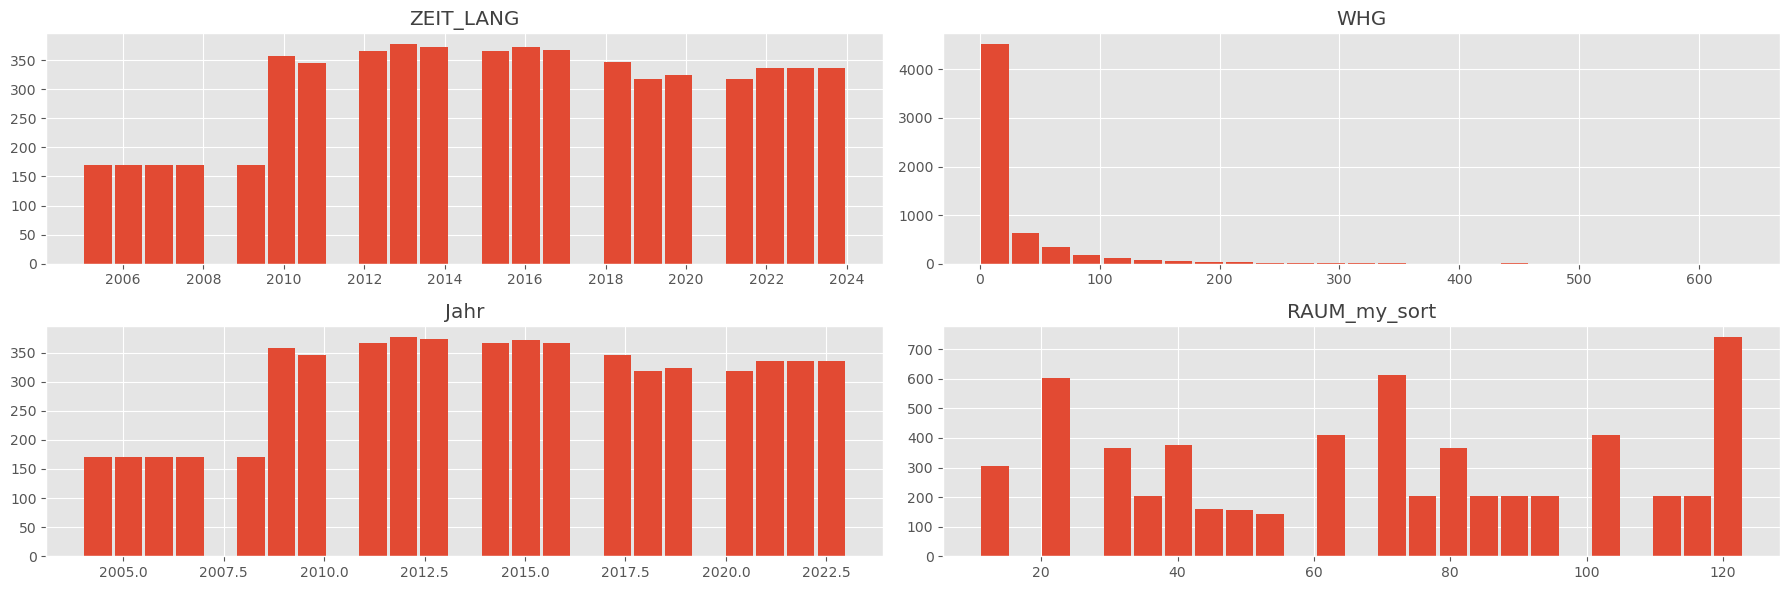

In [24]:
plt.style.use('ggplot')
params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [18, 6],
   }
plt.rcParams.update(params)

try:
    data2betested.hist(bins=25, rwidth=0.9)
    plt.tight_layout()
    plt.show()
except:
    print("No numercial data to plot.") 

### Gibt es Duplikate?

In [25]:
# find duplicate rows
duplicate_rows = data2betested[data2betested.duplicated()]
duplicate_rows

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,ZIM_LANG,ZIM_CODE,ARA_LANG,...,PST_CODE,WHG,KREISEZH_LANG,KREISEZH_CODE,StichtagDatJahr_str,Jahr,RAUM_my_sort
StichtagDatJahr,,,,,,,,,,,,,,,


### Nullwerte und Missings?

In [26]:
data2betested.isnull().sum()

ZEIT_LANG              0
ZEIT_CODE              0
RAUM_LANG              0
RAUM_CODE              0
ZIM_LANG               0
ZIM_CODE               0
ARA_LANG               0
ARA_CODE               0
PST_LANG               0
PST_CODE               0
WHG                    0
KREISEZH_LANG          0
KREISEZH_CODE          0
StichtagDatJahr_str    0
Jahr                   0
RAUM_my_sort           0
dtype: int64

In [27]:
# check missing values with missingno
# https://github.com/ResidentMario/missingno
#import missingno as msno
#msno.matrix(data2betested, labels=True, sort='descending');
#msno.heatmap(data2betested)

### Gruppierungen

In [28]:
agg_jahr = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr']) \
    .agg(sum_WHG=('WHG', 'sum')) \
    .sort_values('Jahr', ascending=False) 
agg_jahr.reset_index().head(3)

,Jahr,sum_WHG
0,2023,14606
1,2022,12094
2,2021,11546


In [29]:
agg_Quarts = data2betested.loc[data_max_date]\
    .groupby(['RAUM_my_sort', 'RAUM_LANG', 'RAUM_CODE']) \
    .agg(sum_WHG=('WHG', 'sum')) \
    .sort_values('RAUM_CODE', ascending=False) 
agg_Quarts.reset_index().head(50)

,RAUM_my_sort,RAUM_LANG,RAUM_CODE,sum_WHG
0,123,Hirzenbach,R00123,472
1,122,Schwamendingen-Mitte,R00122,752
2,121,Saatlen,R00121,49
3,119,Seebach,R00119,2176
4,115,Oerlikon,R00115,1403
5,111,Affoltern,R00111,788
6,102,Wipkingen,R00102,205
7,101,Höngg,R00101,414
8,92,Altstetten,R00092,1255
9,91,Albisrieden,R00091,1215


In [30]:
agg_Kreis = data2betested.loc[data_max_date]\
    .groupby(['KREISEZH_LANG', 'KREISEZH_CODE']) \
    .agg(sum_WHG=('WHG', 'sum')) \
    .sort_values('KREISEZH_CODE', ascending=False) 
agg_Kreis.reset_index().head(50)

,KREISEZH_LANG,KREISEZH_CODE,sum_WHG
0,Kreis 11 (ab 1970),R01800,4367
1,altes Quartier Schwamendingen (1934-1969); Kre...,R01700,1273
2,Kreis 10 (ab 1934),R01500,619
3,Kreis 9 (ab 1934),R01400,2470
4,Kreis 7 (ab 1934),R01300,794
5,Kreis 6 (ab 1934),R01200,819
6,Kreis 8 (ab 1915),R01100,203
7,Kreis 5 (ab 1915),R00800,316
8,Kreis 4 (ab 1915),R00700,254
9,Kreis 3 (ab 1915),R00600,2127


In [31]:
agg_ARA = data2betested.loc[data_max_date]\
    .groupby(['ARA_LANG','ARA_CODE']) \
    .agg(sum_WHG=('WHG', 'sum')) \
    .sort_values('ARA_CODE', ascending=False) 
agg_ARA.reset_index().head(5)

,ARA_LANG,ARA_CODE,sum_WHG
0,Neubau,ARA2001,14606


In [32]:
test = data2betested\
    .groupby(['Jahr','ZIM_LANG', 'ZIM_CODE']) \
    .agg(sum_WHG=('WHG', 'sum')) \
    .sort_values(['Jahr','ZIM_CODE'], ascending=[False, True]) 
test.reset_index().head(12)



,Jahr,ZIM_LANG,ZIM_CODE,sum_WHG
0,2023,"1- und 1,5-Zimmer Wohnung",ZIM0001,1630
1,2023,"2- und 2,5-Zimmer Wohnung",ZIM0002,4834
2,2023,"3- und 3,5-Zimmer Wohnung",ZIM0003,4481
3,2023,"4- und 4,5-Zimmer Wohnung",ZIM0004,2804
4,2023,"5- und 5,5-Zimmer Wohnung",ZIM0005,743
5,2023,6- und mehr-Zimmer Wohnung,ZIM0060,114
6,2022,"1- und 1,5-Zimmer Wohnung",ZIM0001,1275
7,2022,"2- und 2,5-Zimmer Wohnung",ZIM0002,3661
8,2022,"3- und 3,5-Zimmer Wohnung",ZIM0003,4028
9,2022,"4- und 4,5-Zimmer Wohnung",ZIM0004,2396


In [33]:
agg_PST = data2betested.loc[data_max_date]\
    .groupby(['PST_LANG', 'PST_CODE']) \
    .agg(sum_WHG=('WHG', 'sum')) \
    .sort_values('PST_CODE', ascending=False) 
agg_PST.reset_index().head(5)

,PST_LANG,PST_CODE,sum_WHG
0,"Bewilligt harmonisiert (Bewillgt, Freigegeben,...",PST0101,7783
1,Baubegonnen,PST0006,6823


In [34]:
agg_ZIM= data2betested.loc[data_max_date]\
    .groupby(['ZIM_LANG', 'ZIM_CODE',]) \
    .agg(sum_WHG=('WHG', 'sum')) \
    .sort_values('ZIM_CODE', ascending=False) 
agg_ZIM.reset_index().head(7)

,ZIM_LANG,ZIM_CODE,sum_WHG
0,6- und mehr-Zimmer Wohnung,ZIM0060,114
1,"5- und 5,5-Zimmer Wohnung",ZIM0005,743
2,"4- und 4,5-Zimmer Wohnung",ZIM0004,2804
3,"3- und 3,5-Zimmer Wohnung",ZIM0003,4481
4,"2- und 2,5-Zimmer Wohnung",ZIM0002,4834
5,"1- und 1,5-Zimmer Wohnung",ZIM0001,1630


### Zeitpunkte und Zeiträume abfragen

A particular powerful feature of the Pandas DataFrame is its indexing capability that also works using time-based entities, such as dates and times. We have already created the index above, so let's put it to use.

In [35]:
data2betested.loc[data_max_date].head(2)
#data2betested.loc["2021-10-31":"2021-11-30"].head(2)

,ZEIT_LANG,ZEIT_CODE,RAUM_LANG,RAUM_CODE,ZIM_LANG,ZIM_CODE,ARA_LANG,...,PST_CODE,WHG,KREISEZH_LANG,KREISEZH_CODE,StichtagDatJahr_str,Jahr,RAUM_my_sort
StichtagDatJahr,,,,,,,,,,,,,,,
2023-12-31,2023-12-31,Z31122023,Höngg,R00101,"3- und 3,5-Zimmer Wohnung",ZIM0003,Neubau,...,PST0006,24,Kreis 10 (ab 1934),R01500,2023-12-31,2023,101
2023-12-31,2023-12-31,Z31122023,Sihlfeld,R00034,"5- und 5,5-Zimmer Wohnung",ZIM0005,Neubau,...,PST0006,1,Kreis 3 (ab 1915),R00600,2023-12-31,2023,34


In [36]:
data2betested.columns

Index(['ZEIT_LANG', 'ZEIT_CODE', 'RAUM_LANG', 'RAUM_CODE', 'ZIM_LANG', 'ZIM_CODE', 'ARA_LANG',
       'ARA_CODE', 'PST_LANG', 'PST_CODE', 'WHG', 'KREISEZH_LANG', 'KREISEZH_CODE',
       'StichtagDatJahr_str', 'Jahr', 'RAUM_my_sort'],
      dtype='object')

### Visualisierungen nach Zeitausschnitten

#### Entwicklung der projektierten Neubauwohnungen

In [37]:
myAgg1 = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr', 'Jahr']) \
    .agg(sum_WHG=('WHG', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=False) 
myAgg1.reset_index().head(7)

,StichtagDatJahr,Jahr,sum_WHG
0,2023-12-31,2023,14606
1,2022-12-31,2022,12094
2,2021-12-31,2021,11546
3,2020-12-31,2020,11261
4,2019-12-31,2019,8768
5,2018-12-31,2018,7605
6,2017-12-31,2017,9119


In [38]:
grafik1 = mypy_dv.plot_altair_multiline_highlight(
    data = myAgg1.reset_index()
    , x = 'StichtagDatJahr:T'
    , y = 'sum_WHG:Q'
    , myTitle = "Entwicklung der projektierten Neubauwohnungen seit "+str(data2betested.index.year.min())
    , x_beschriftung = 'Jahr'
    , y_beschriftung = 'Anz. Wohnungen'
    , warning_status  = "ignore"
    , category=''
    , category_beschriftung=''
)
grafik1

alt.LayerChart(...)

Speichere diese Grafik mit Zeitstempel:

In [39]:
grafic_name = package_name+"_alt1_total"+date_today+".png"
print('grafiken_testing/'+grafic_name)
#grafik1.save('grafiken_testing/'+grafic_name+'.html', embed_options={'renderer':'svg'})
grafik1.save('/content/colab/losd/grafiken_testing/'+grafic_name)

grafiken_testing/bau502od5022_alt1_total_2024-07-04.png


#### Entwicklung projektierter Neubauwohnungen Stadtquartier seit ...

In [40]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg2 = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['StichtagDatJahr', 'RAUM_LANG', 'RAUM_CODE']) \
    .agg(sum_WHG=('WHG', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg2.reset_index().head(3)


,StichtagDatJahr,RAUM_LANG,RAUM_CODE,sum_WHG
0,2004-12-31,Affoltern,R00111,39
1,2004-12-31,Mühlebach,R00082,23
2,2004-12-31,Oberstrass,R00063,4


In [41]:
grafik2 = mypy_dv.plot_altair_multiline_highlight(
    data = myAgg2.reset_index()
    , x = 'StichtagDatJahr:T'
    , y = 'sum_WHG:Q'
    , myTitle = "Entwicklung projektierter Neubauwohnungen nach Stadtquartier seit "+str(data2betested.index.year.min())
    , x_beschriftung = 'Jahr'
    , y_beschriftung = 'Anz. Wohnungen'
    , warning_status  = "ignore"
    , category='RAUM_LANG:N'
    , category_beschriftung='Stadtquartier'
)
grafik2

alt.LayerChart(...)

In [42]:
grafic_name = package_name+"_alt2_raum_zeit"+date_today+".png"
print('grafiken_testing/'+grafic_name)

grafik2.save('/content/colab/losd/grafiken_testing/'+grafic_name)

grafiken_testing/bau502od5022_alt2_raum_zeit_2024-07-04.png


#### Entwicklung ... nach Stadtquartier der Kreise 10-12, 1941-1981

In [43]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAgg3 = data2betested\
    .groupby(['StichtagDatJahr', 'RAUM_CODE', 'RAUM_LANG', 'RAUM_my_sort']) \
    .agg(sum_WHG=('WHG', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg3.reset_index().head(3)


,StichtagDatJahr,RAUM_CODE,RAUM_LANG,RAUM_my_sort,sum_WHG
0,2004-12-31,R00011,Rathaus,11,0
1,2004-12-31,R00073,Hirslanden,73,0
2,2004-12-31,R00074,Witikon,74,42


In [44]:
grafik3 = mypy_dv.plot_altair_multiline_highlight(
    data = myAgg3.reset_index().query('RAUM_my_sort>100')
    , x = 'StichtagDatJahr:T'
    , y = 'sum_WHG:Q'
    , myTitle = "Entwicklung projektierten Neubauwohnungen nach ausgewählten Stadtquartieren, seit "+str(data2betested.index.year.min())
    , x_beschriftung = 'Jahr'
    , y_beschriftung = 'Anz. Wohnungen'
    , warning_status  = "ignore"
    , category='RAUM_LANG:N'
    , category_beschriftung='Stadtquartier'
)
grafik3

alt.LayerChart(...)

#### Entwicklung projektierten Neubauwohnungen nach Projektstatus

In [45]:
myAgg4 = data2betested\
    .groupby(['StichtagDatJahr', 'ARA_LANG','ARA_CODE', 'PST_LANG', 'PST_CODE']) \
    .agg(sum_WHG=('WHG', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg4.reset_index().tail(3)

,StichtagDatJahr,ARA_LANG,ARA_CODE,PST_LANG,PST_CODE,sum_WHG
32,2022-12-31,Neubau,ARA2001,"Bewilligt harmonisiert (Bewillgt, Freigegeben,...",PST0101,4837
33,2023-12-31,Neubau,ARA2001,Baubegonnen,PST0006,6823
34,2023-12-31,Neubau,ARA2001,"Bewilligt harmonisiert (Bewillgt, Freigegeben,...",PST0101,7783


In [46]:
grafik4 = mypy_dv.plot_altair_multiline_highlight(
    data = myAgg4.reset_index()
    , x = 'StichtagDatJahr:T'
    , y = 'sum_WHG:Q'
    , myTitle = "Entwicklung projektierten Neubauwohnungen nach Projektstatus, seit "+str(data2betested.index.year.min())
    , x_beschriftung = 'Jahr'
    , y_beschriftung = 'Anz. Wohnungen'
    , warning_status  = "ignore"
    , category='PST_LANG:N'
    , category_beschriftung='Projektstatus'
)
grafik4

alt.LayerChart(...)

##### Vergleich mit SASA: Entwicklung projektierten Neubauwohnungen nach Projektstatus

In [47]:
sasa_data2betested.columns

Index(['StichtagDatJahr', 'DatenstandCd', 'QuarSort', 'QuarCd', 'QuarLang', 'KreisSort', 'KreisCd',
       'KreisLang', 'ProjektStatusSSZPubl1Sort', 'ProjektStatusSSZPubl1Cd',
       'ProjektStatusSSZPubl1Lang', 'ArtArbeitenSort', 'ArtArbeitenCd', 'ArtArbeitenLang',
       'AnzZimmerLevel2Sort_noDM', 'AnzZimmerLevel2Cd_noDM', 'AnzZimmerLevel2Lang_noDM',
       'AnzWhgStat'],
      dtype='object')

In [48]:
grafic_name = package_name+"_alt3_pst_zeit"+date_today+".png"
print('grafiken_testing/'+grafic_name)

grafik4.save('/content/colab/losd/grafiken_testing/'+grafic_name)

grafiken_testing/bau502od5022_alt3_pst_zeit_2024-07-04.png


In [49]:
myAgg4_sasa = sasa_data2betested\
    .groupby(['StichtagDatJahr', 'ArtArbeitenSort', 'ArtArbeitenCd', 'ArtArbeitenLang','ProjektStatusSSZPubl1Sort', 'ProjektStatusSSZPubl1Cd','ProjektStatusSSZPubl1Lang']) \
    .agg(sum_WHG=('AnzWhgStat', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg4_sasa.reset_index().head(3)

,StichtagDatJahr,ArtArbeitenSort,ArtArbeitenCd,ArtArbeitenLang,ProjektStatusSSZPubl1Sort,ProjektStatusSSZPubl1Cd,ProjektStatusSSZPubl1Lang,sum_WHG
0,2009-01-01,1,N,Neubau,2,2,Bewilligt harmonisiert,2933
1,2009-01-01,1,N,Neubau,3,3,Baubegonnen,4176
2,2010-01-01,1,N,Neubau,2,2,Bewilligt harmonisiert,2858


In [50]:
grafik4 = mypy_dv.plot_altair_multiline_highlight(
    data = myAgg4_sasa.reset_index()
    , x = 'StichtagDatJahr:T'
    , y = 'sum_WHG:Q'
    , myTitle = "Entwicklung projektierten Neubauwohnungen (SASA) nach Projektstatus, seit "
    , x_beschriftung = 'Jahr'
    , y_beschriftung = 'Anz. Wohnungen'
    , warning_status  = "ignore"
    , category='ProjektStatusSSZPubl1Lang:N'
    , category_beschriftung='Projektstatus'
)
grafik4

alt.LayerChart(...)

#### Entwicklung projektierten Neubauwohnungen nach Zimmerzahl

In [51]:
myAgg5 = data2betested\
    .groupby(['StichtagDatJahr', 'ZIM_LANG', 'ZIM_CODE']) \
    .agg(sum_WHG=('WHG', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAgg5.reset_index().head(3)

,StichtagDatJahr,ZIM_LANG,ZIM_CODE,sum_WHG
0,2004-12-31,"1- und 1,5-Zimmer Wohnung",ZIM0001,72
1,2004-12-31,"2- und 2,5-Zimmer Wohnung",ZIM0002,258
2,2004-12-31,"3- und 3,5-Zimmer Wohnung",ZIM0003,398


In [52]:
grafik5 = mypy_dv.plot_altair_multiline_highlight(
    data = myAgg5.reset_index()
    , x = 'StichtagDatJahr:T'
    , y = 'sum_WHG:Q'
    , myTitle = "Entwicklung der projektierten Neubauwohnungen nach Zimmerzahl, seit "+str(data2betested.index.year.min())
    , x_beschriftung = 'Jahr'
    , y_beschriftung = 'Anz. Wohnungen'
    , warning_status  = "ignore"
    , category='ZIM_LANG:N'
    , category_beschriftung='Anzahl Zimmer:'
)
grafik5

alt.LayerChart(...)

In [53]:
grafic_name = package_name+"_alt3_zim_zeit"+date_today+".png"
print('grafiken_testing/'+grafic_name)

grafik5.save('/content/colab/losd/grafiken_testing/'+grafic_name)

grafiken_testing/bau502od5022_alt3_zim_zeit_2024-07-04.png


#### Barcharts mit Seaborn

In [54]:
#myAgg = data2betested.loc["2008-11-30":"2021-10-31"]
myAggBar = data2betested\
    .groupby(['StichtagDatJahr', 'ZIM_LANG', 'ZIM_CODE','StichtagDatJahr_str', 'Jahr']) \
    .agg(sum_WHG=('WHG', 'sum')) \
    .sort_values('StichtagDatJahr', ascending=True) 

myAggBar.reset_index().head(5)

,StichtagDatJahr,ZIM_LANG,ZIM_CODE,StichtagDatJahr_str,Jahr,sum_WHG
0,2004-12-31,"1- und 1,5-Zimmer Wohnung",ZIM0001,2004-12-31,2004,72
1,2004-12-31,"2- und 2,5-Zimmer Wohnung",ZIM0002,2004-12-31,2004,258
2,2004-12-31,"3- und 3,5-Zimmer Wohnung",ZIM0003,2004-12-31,2004,398
3,2004-12-31,"4- und 4,5-Zimmer Wohnung",ZIM0004,2004-12-31,2004,702
4,2004-12-31,"5- und 5,5-Zimmer Wohnung",ZIM0005,2004-12-31,2004,329


In [55]:
#help(sns.catplot)     

In [56]:
#Stile for the following sns graphs
sns.set_theme(style="whitegrid")

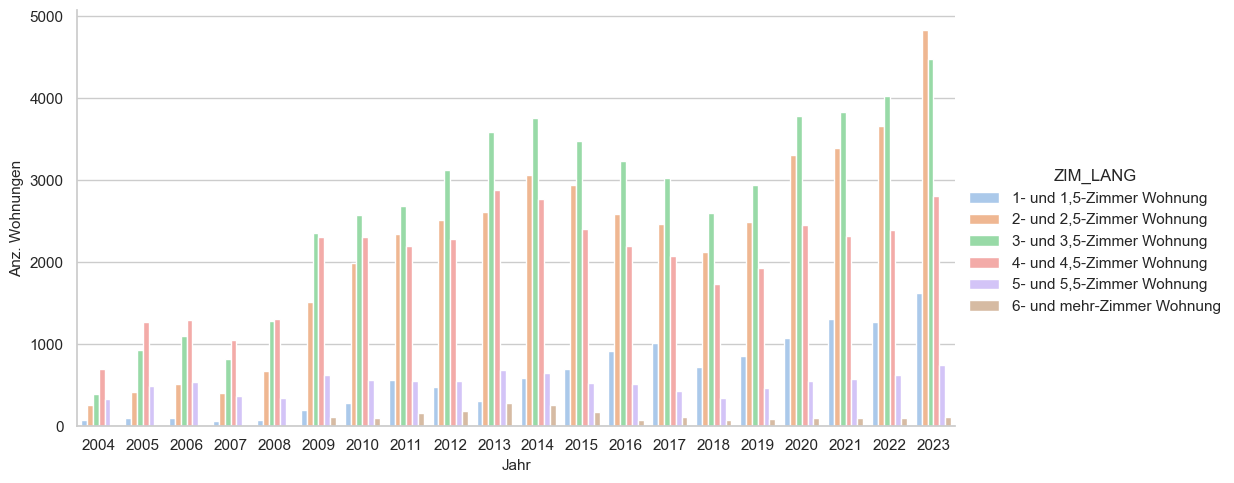

In [57]:
#sns.color_palette("flare", as_cmap=True)
myHist = sns.catplot(x="Jahr"
            , y="sum_WHG"
            , hue="ZIM_LANG"
            , kind="bar" #boxen, violin, --> wenn die aggregation nicht genau den werten in der grafik entspricht
            , palette="pastel" #, color="green"
            , height=5
            , aspect=2
            , order=None, legend_out=True
            ,data=myAggBar.reset_index()
           )
myHist.set_xlabels('Jahr', fontsize=11) # not set_label
myHist.set_ylabels('Anz. Wohnungen', fontsize=11)

myHist


In [58]:
grafic_name = package_name+"_bar_ziza_zeit"+date_today+".png"
print('grafiken_testing/'+grafic_name)

myHist.savefig('/content/colab/losd/grafiken_testing/'+grafic_name)

grafiken_testing/bau502od5022_bar_ziza_zeit_2024-07-04.png


#### Faced Grids

In [59]:
myFG = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr','StichtagDatJahr_str', 'RAUM_LANG', 'RAUM_CODE', 'RAUM_my_sort', 'PST_LANG', 'PST_CODE']) \
    .agg(sum_WHG=('WHG', 'sum')) \
    .sort_values(['RAUM_my_sort','Jahr'], ascending=[True, True]) 

myFG.head(2)

,,,,,,,sum_WHG
Jahr,StichtagDatJahr_str,RAUM_LANG,RAUM_CODE,RAUM_my_sort,PST_LANG,PST_CODE,
2004,2004-12-31,Rathaus,R00011,11,Baubegonnen,PST0006,0
2005,2005-12-31,Rathaus,R00011,11,Baubegonnen,PST0006,0


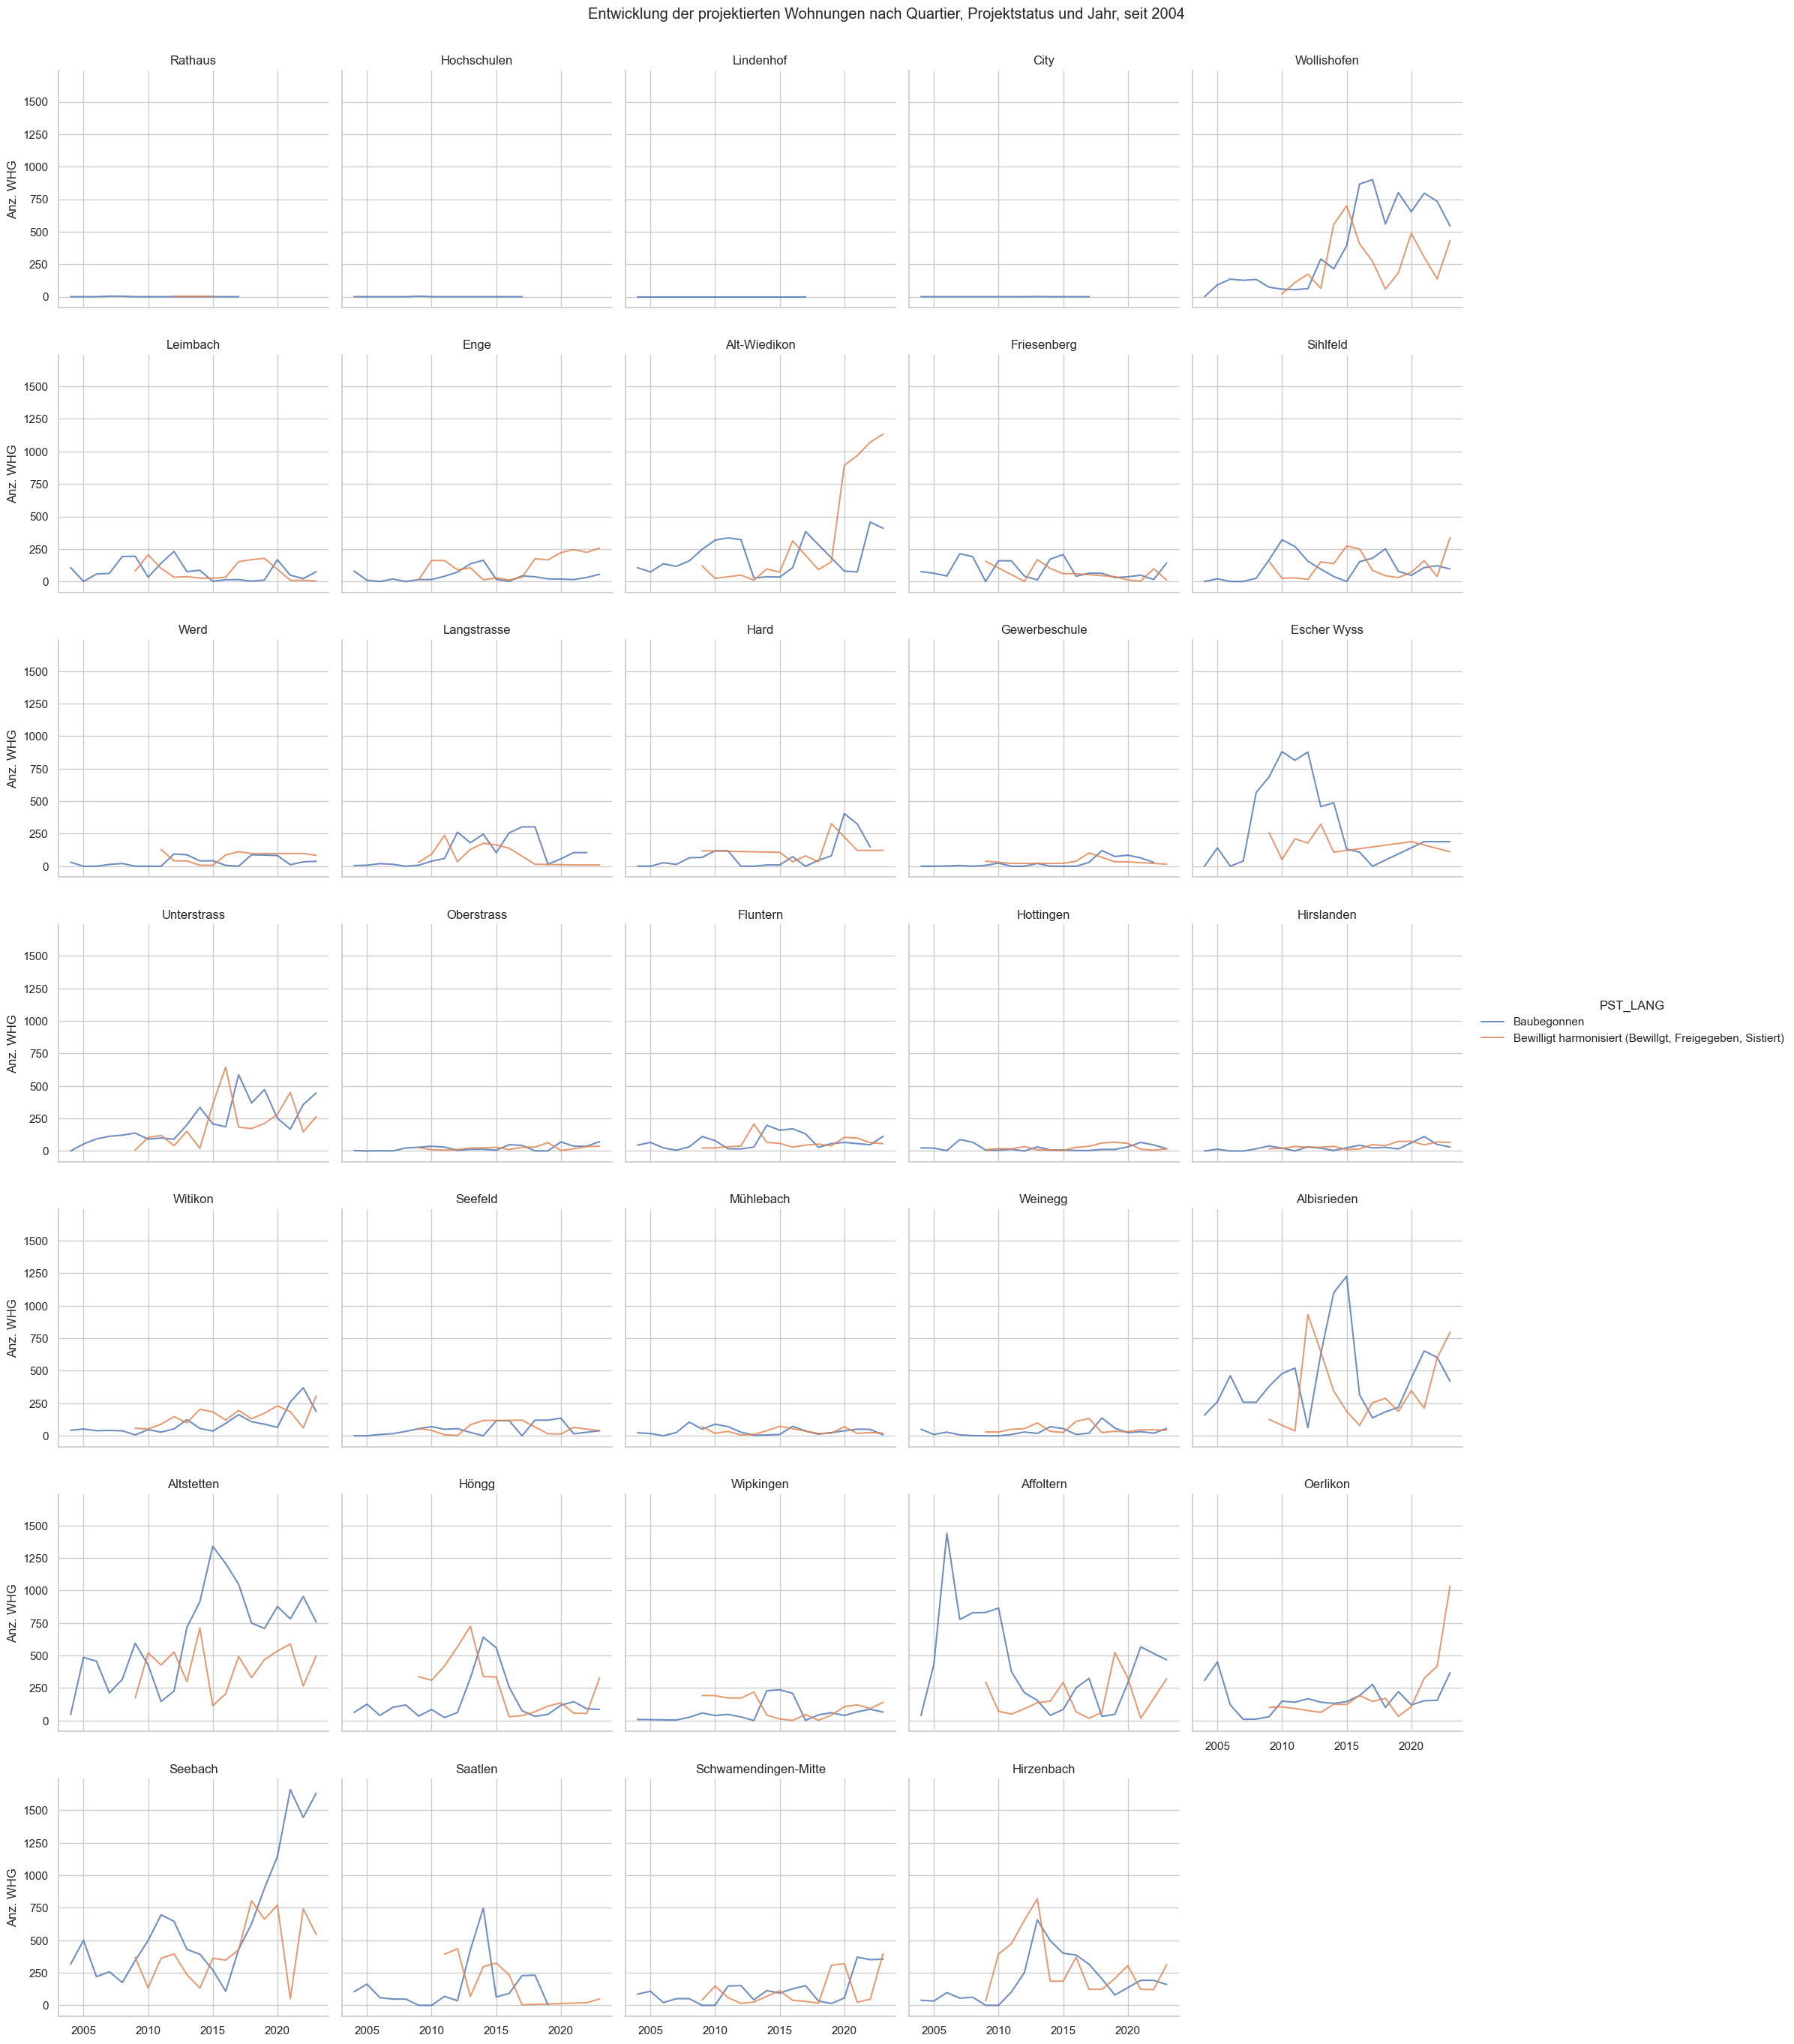

In [60]:
faced_grid1 = mypy_dv.plot_sns_facetgrid(
    data = myFG.reset_index()
    , col = "RAUM_LANG"
    , hue = "PST_LANG"
    , col_wrap = 5
    , height = 3
    , grafiktyp = sns.lineplot
    , x = "Jahr"
    , y = "sum_WHG"
    , ylabel= "Anz. WHG"
    , myTitle="Entwicklung der projektierten Wohnungen nach Quartier, Projektstatus und Jahr, seit "+str(data2betested.index.year.min())
    )

In [61]:
grafic_name = package_name+"_fg_raum_projstat_zeit"+date_today+".png"
print('grafiken_testing/'+grafic_name)

faced_grid1.savefig('/content/colab/losd/grafiken_testing/'+grafic_name)

grafiken_testing/bau502od5022_fg_raum_projstat_zeit_2024-07-04.png


In [62]:
myFG2 = data2betested.loc[data_min_date:data_max_date]\
    .groupby(['Jahr','StichtagDatJahr_str', 'RAUM_LANG', 'RAUM_CODE', 'RAUM_my_sort', 'ZIM_LANG', 'ZIM_CODE']) \
    .agg(sum_WHG=('WHG', 'sum')) \
    .sort_values(['RAUM_my_sort','Jahr'], ascending=[True, True]) 

myFG2.head(2)

sum_WHG
Jahr StichtagDatJahr_str RAUM_LANG RAUM_CODE RAUM_my_sort ZIM_LANG                  ZIM_CODE         
2004 2004-12-31          Rathaus   R00011    11           1- und 1,5-Zimmer Wohnung ZIM0001         0
                                                          2- und 2,5-Zimmer Wohnung ZIM0002         0

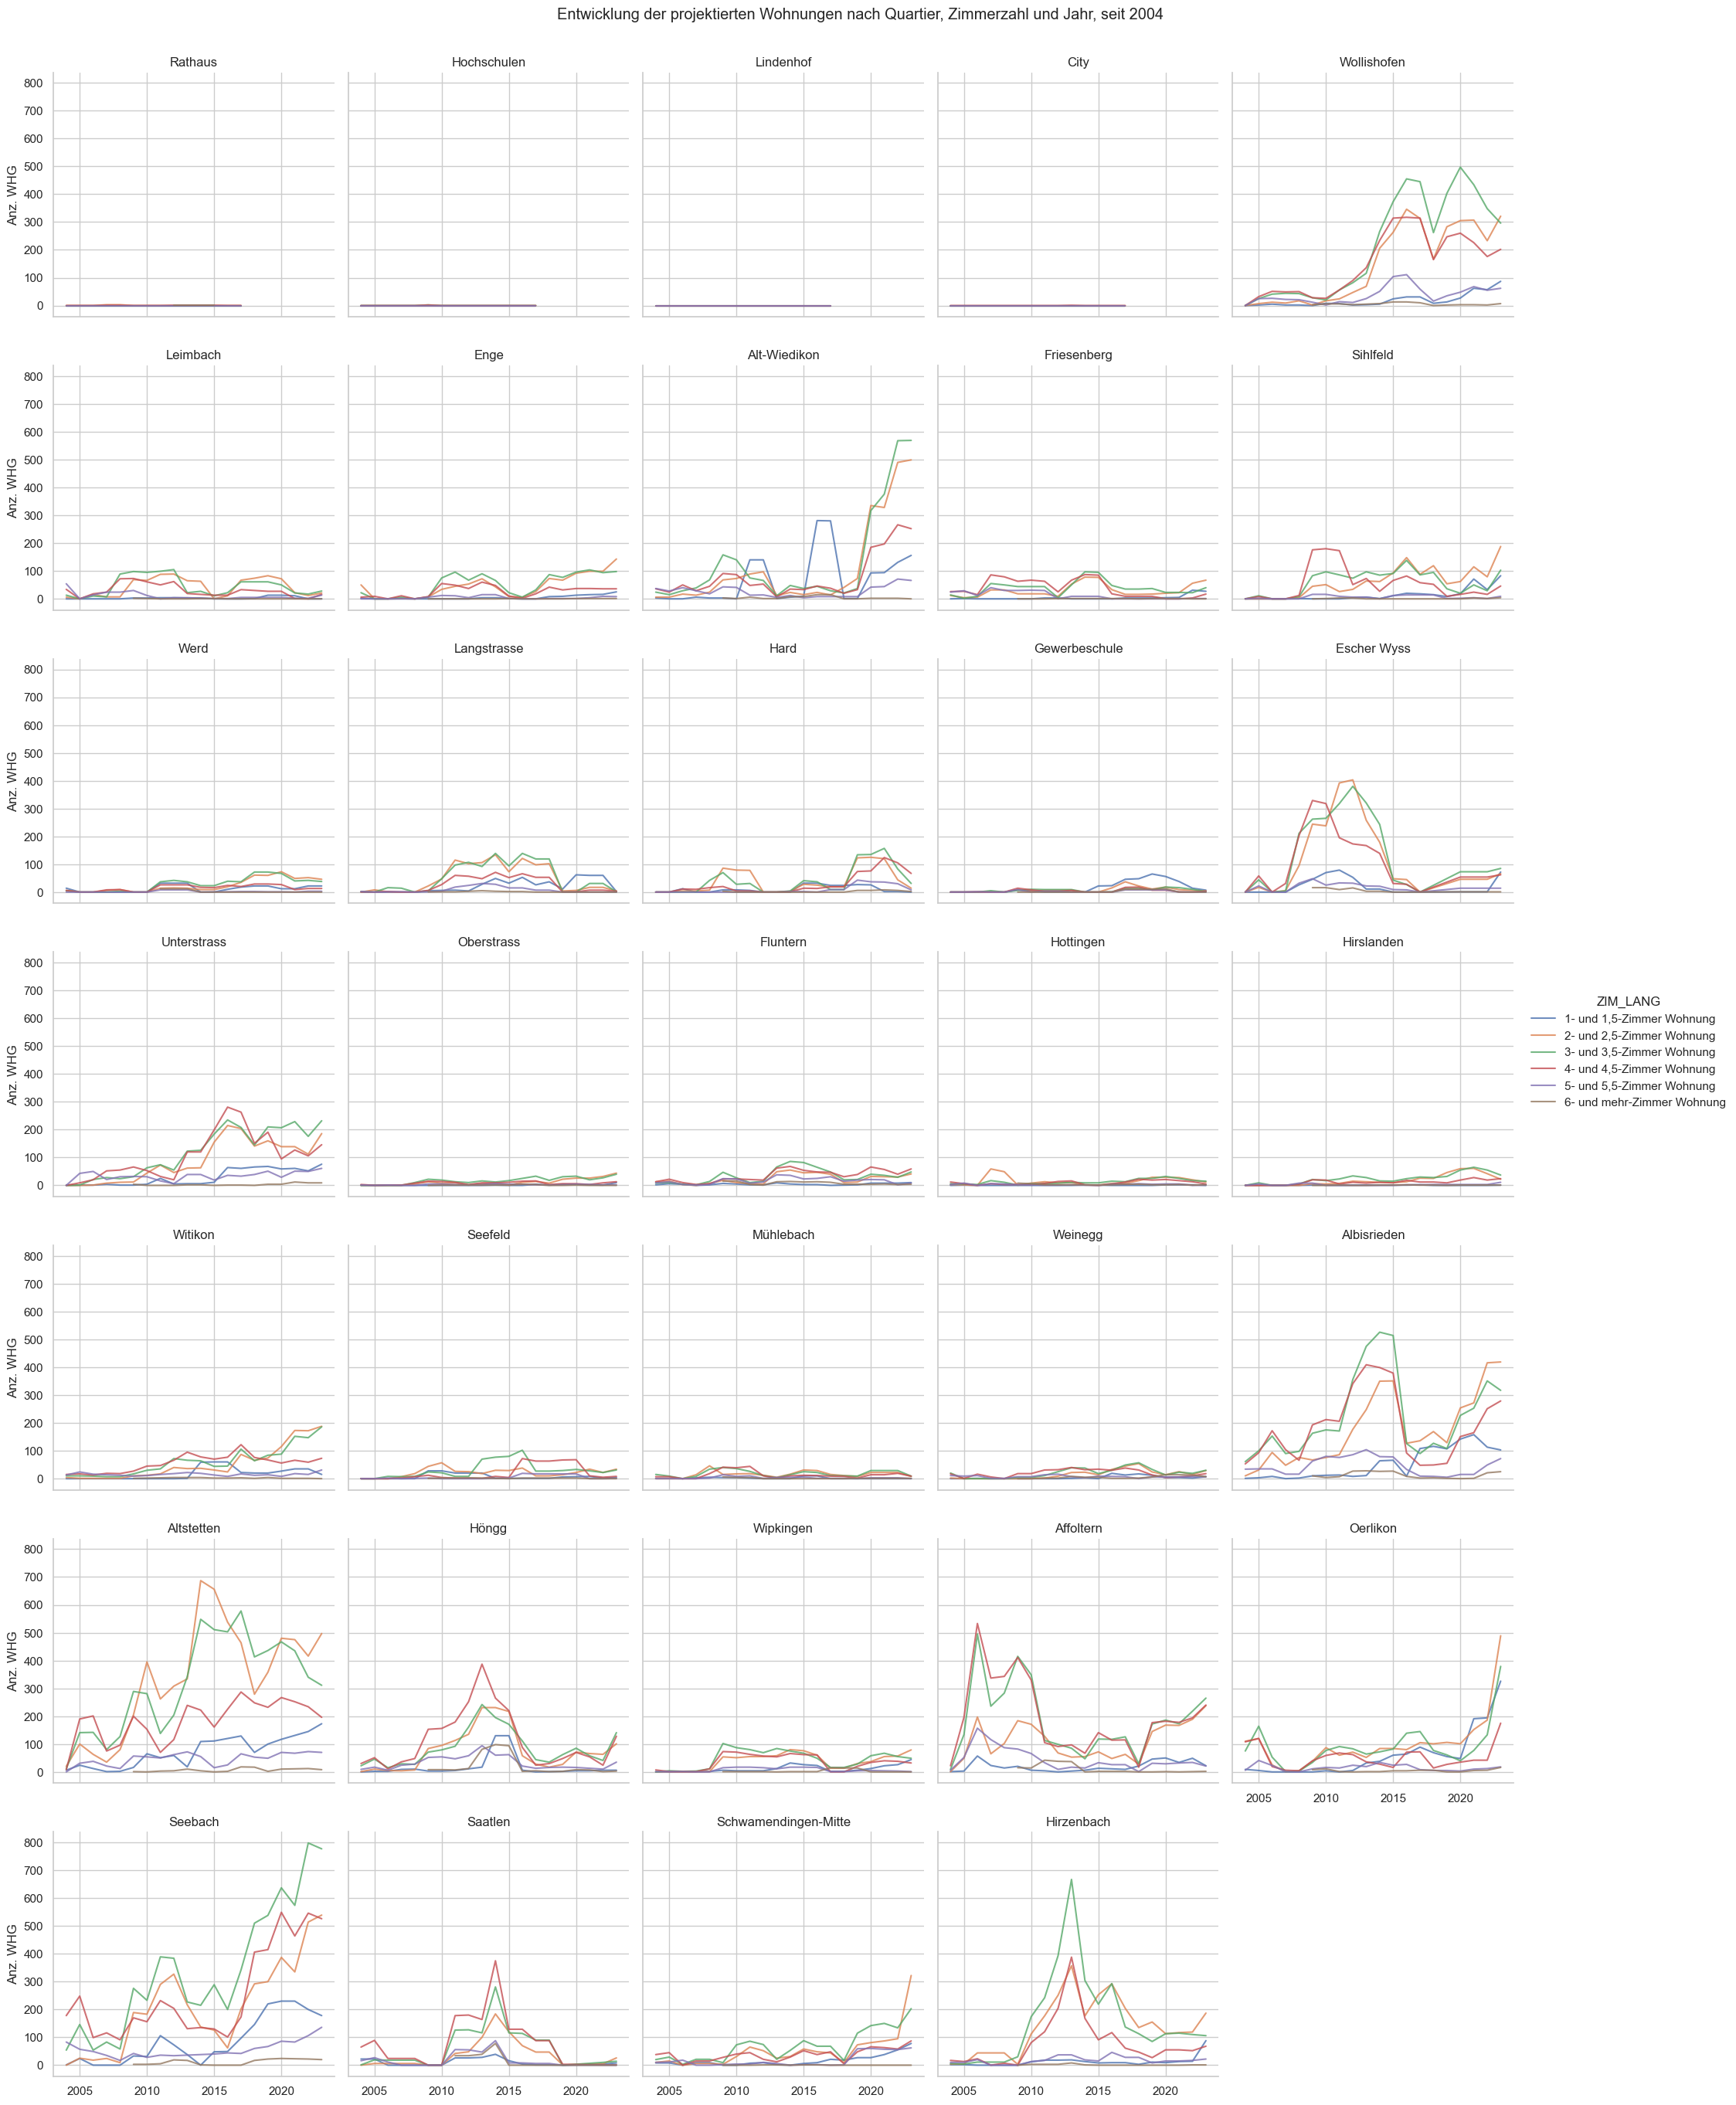

In [63]:
faced_grid2 = mypy_dv.plot_sns_facetgrid(
    data = myFG2.reset_index()
    , col = "RAUM_LANG"
    , hue = "ZIM_LANG"
    , col_wrap = 5
    , height = 3
    , grafiktyp = sns.lineplot
    , x = "Jahr"
    , y = "sum_WHG"
    , ylabel= "Anz. WHG"
    , myTitle="Entwicklung der projektierten Wohnungen nach Quartier, Zimmerzahl und Jahr, seit "+str(data2betested.index.year.min())
    )

In [64]:
grafic_name = package_name+"_fg_raum_zim_zeit"+date_today+".png"
print('grafiken_testing/'+grafic_name)

faced_grid2.savefig('/content/colab/losd/grafiken_testing/'+grafic_name)

grafiken_testing/bau502od5022_fg_raum_zim_zeit_2024-07-04.png


In [65]:
data2betested.columns

Index(['ZEIT_LANG', 'ZEIT_CODE', 'RAUM_LANG', 'RAUM_CODE', 'ZIM_LANG', 'ZIM_CODE', 'ARA_LANG',
       'ARA_CODE', 'PST_LANG', 'PST_CODE', 'WHG', 'KREISEZH_LANG', 'KREISEZH_CODE',
       'StichtagDatJahr_str', 'Jahr', 'RAUM_my_sort'],
      dtype='object')

#### Treemaps

In [66]:
myTM = data2betested.loc[data_max_date]\
    .groupby(['Jahr','StichtagDatJahr_str', 'RAUM_LANG', 'RAUM_CODE', 'RAUM_my_sort', 'KREISEZH_LANG', 'KREISEZH_CODE','ZIM_LANG', 'ZIM_CODE', 'PST_LANG', 'PST_CODE']) \
    .agg(sum_WHG=('WHG', 'sum')) \
    .sort_values(['RAUM_my_sort','Jahr'], ascending=[True, True]) 

myTM.reset_index().head(2)

,Jahr,StichtagDatJahr_str,RAUM_LANG,RAUM_CODE,RAUM_my_sort,KREISEZH_LANG,KREISEZH_CODE,ZIM_LANG,ZIM_CODE,PST_LANG,PST_CODE,sum_WHG
0,2023,2023-12-31,Wollishofen,R00021,21,Kreis 2 (ab 1893),R00200,"1- und 1,5-Zimmer Wohnung",ZIM0001,Baubegonnen,PST0006,39
1,2023,2023-12-31,Wollishofen,R00021,21,Kreis 2 (ab 1893),R00200,"1- und 1,5-Zimmer Wohnung",ZIM0001,"Bewilligt harmonisiert (Bewillgt, Freigegeben,...",PST0101,48


In [67]:
#, levels = "'GNA_LANG', 'BAP_LANG','KREISEZH_LANG'"

treeMap1 = mypy_dv.plot_px_treemap(
    data=myTM.reset_index()
    ,levels=["PST_LANG",  "ZIM_LANG","KREISEZH_LANG"]
    ,values="sum_WHG"
    ,color="ZIM_LANG"
    ,myHeaderTitle="Projektierte Neubauwohnungen nach Status, Zimmerzahl und Stadtkreis, "+data_max_date
    ,color_discrete_map={'(?)':'lightgrey', 'Wohnen':'lightblue'}                
    #,margin_val_bottom=25
)
treeMap1

path: [<plotly.express._special_inputs.Constant object at 0x000001F466C0F450>, 'PST_LANG', 'ZIM_LANG', 'KREISEZH_LANG']
Typ von path: <class 'list'>


In [68]:
grafic_name = package_name+"_tm_prjstat_ziza_kreis"+date_today+".png"
print(grafic_name)

#treeMap1.write_image('grafiken_testing/'+grafic_name)

bau502od5022_tm_prjstat_ziza_kreis_2024-07-04.png


In [69]:
#, levels = "'GNA_LANG', 'BAP_LANG','KREISEZH_LANG'"

treeMap2 = mypy_dv.plot_px_treemap(
    data=myTM.reset_index()
    ,levels=["ZIM_LANG","PST_LANG","RAUM_LANG"]
    ,values="sum_WHG"
    ,color="RAUM_LANG"
    ,myHeaderTitle="Projektierte Neubauwohnungen nach Status, Zimmerzahl und Stadtkreis, "+data_max_date
    ,color_discrete_map={'(?)':'lightgrey', 'Wohnen':'lightblue'}                
    #,margin_val_bottom=25
)
treeMap2

path: [<plotly.express._special_inputs.Constant object at 0x000001F468703DD0>, 'ZIM_LANG', 'PST_LANG', 'RAUM_LANG']
Typ von path: <class 'list'>


In [70]:
grafic_name = package_name+"_tm_ziza_prjstat_quartier"+date_today+".png"
print(grafic_name)

#treeMap1.write_image('grafiken_testing/'+grafic_name)

bau502od5022_tm_ziza_prjstat_quartier_2024-07-04.png


## ---------------------- hier Plausi beendet

Übersicht zu LOSD-Jobs:
[Sharepoint](https://kollaboration.intranet.stzh.ch/orga/ssz-produkte/Lists/SASA_Outputs/OGD%20Metadaten.aspx#InplviewHasheb69a2c0-ed94-4ef2-91a5-3b19f038e442=FilterField1%3DMetadaten%255Fx002d%255FPublikations%255Fx00-FilterValue1%3DINT)